In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# Import both data loading functions
from prepare_data import load_clean_dataframe  # Original
from prepare_data_pdf_content import create_modeling_dataset  # Enhanced

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

def threshold_for_recall(scores, y_true, recall_target=0.85):
    """Return the highest threshold that still achieves recall ≥ target."""
    prec, rec, thr = precision_recall_curve(y_true, scores)
    candidates = [t for r, t in zip(rec[:-1], thr) if r >= recall_target]
    return max(candidates) if candidates else thr.min()

def evaluate_model(model, X, y, model_name, cv_folds=5):
    """Evaluate model with cross-validation and return metrics."""
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name}")
    print(f"{'='*60}")
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    
    # Find threshold for 85% recall
    thr = threshold_for_recall(proba, y, recall_target=0.85)
    y_pred = (proba >= thr).astype(int)
    
    # Calculate metrics
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    results = {
        'model_name': model_name,
        'threshold': thr,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'true_negatives': tn,
        'documents_to_review': tp + fp,
        'missed_opportunities': fn,
        'dataset_size': len(y),
        'positive_ratio': y.mean()
    }
    
    print(f"Threshold for 85% recall: {thr:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"Documents to review: {tp + fp}")
    print(f"Missed opportunities: {fn}")
    
    return results, proba, y_pred

In [2]:
# Load Original Dataset (Model A)
print("Loading original dataset...")
df_original = load_clean_dataframe(labelled_only=True)

# Feature engineering for original model
df_original["title_len"] = df_original["title"].str.len()
df_original["contains_date"] = df_original["title"].str.contains(r"\b20\d{2}\b", regex=True).astype(int)
df_original["has_pdf"] = df_original["pdf_url"].notna() & df_original["pdf_url"].str.strip().ne("")
df_original["has_pdf"] = df_original["has_pdf"].astype(int)

# Define original features
text_col_original = "title"
cat_cols_original = ["ca", "procedure"]
num_cols_original = ["has_pdf", "title_len", "contains_date"]

y_original = df_original["bid"].astype(int).values
X_original = df_original.drop(columns=["bid"])

print(f"Original dataset shape: {X_original.shape}")
print(f"Original class distribution: {np.bincount(y_original)}")
print(f"Original positive class ratio: {y_original.mean():.3f}")

Loading original dataset...
Original dataset shape: (2094, 7)
Original class distribution: [1955  139]
Original positive class ratio: 0.066


/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ca"].fillna("", inplace=True)
/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

In [3]:
# Load PDF Content Enhanced Dataset (Model B)
print("Loading PDF content enhanced dataset...")
df_enhanced = create_modeling_dataset(
    labelled_only=True,
    extract_lot_section_only=True,
    include_codes_onehot=True,
    min_pdf_text_length=50,
    min_codes_for_analysis=0
)

# Filter to only include tenders with PDF text content
df_enhanced = df_enhanced[df_enhanced['has_pdf_content'] == 1].copy()

# Define enhanced features
cat_cols_enhanced = ["ca", "procedure"]
num_cols_enhanced = ["codes_count", "pdf_text_length"]
code_cols_enhanced = [col for col in df_enhanced.columns if col.startswith('code_')]
num_cols_enhanced.extend(code_cols_enhanced)

# Create features dataframe (exclude target and metadata columns)
exclude_cols = ["bid", "has_pdf_content", "has_codes"]
optional_exclude = ["resource_id", "extraction_timestamp", "processing_status"]
for col in optional_exclude:
    if col in df_enhanced.columns:
        exclude_cols.append(col)

y_enhanced = df_enhanced["bid"].astype(int).values
X_enhanced = df_enhanced.drop(columns=exclude_cols)

print(f"Enhanced dataset shape: {X_enhanced.shape}")
print(f"Enhanced class distribution: {np.bincount(y_enhanced)}")
print(f"Enhanced positive class ratio: {y_enhanced.mean():.3f}")
print(f"Code features: {len(code_cols_enhanced)}")
print(f"Total numerical features: {len(num_cols_enhanced)}")

Loading PDF content enhanced dataset...
SQL Query: 
    SELECT 
        tr.*,
        pc.pdf_text,
        pc.detected_codes,
        pc.codes_count,
        pc.extraction_timestamp,
        pc.processing_status
    FROM tender_records tr
    LEFT JOIN pdf_content pc ON tr.resource_id = CAST(pc.resource_id AS BIGINT)
    
Enhanced dataset shape: (1443, 67)
Enhanced class distribution: [1346   97]
Enhanced positive class ratio: 0.067
Code features: 54
Total numerical features: 56


/mnt/c/Users/rober/GitHub/module_2/python/db_utils_pdf_content.py:209: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pdf_text'].fillna("", inplace=True)
/mnt/c/Users/rober/GitHub/module_2/python/db_utils_pdf_content.py:210: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [4]:
# Create Original Model (Model A)
print("Creating Original TF-IDF LinearSVM Model...")

tfidf_vectorizer_original = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_features=40_000,
    strip_accents="unicode",
    lowercase=True,
)

preprocess_original = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf_vectorizer_original, text_col_original),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_original),
        ("num", StandardScaler(), num_cols_original),
    ]
)

base_clf_original = LinearSVC(
    max_iter=2000,
    class_weight="balanced",
    dual=False,
    random_state=42,
)

pipe_original = Pipeline([("prep", preprocess_original), ("clf", base_clf_original)])
model_original = CalibratedClassifierCV(pipe_original, cv=3, method="sigmoid")

print(f"Original model created with {tfidf_vectorizer_original.max_features:,} TF-IDF features")

Creating Original TF-IDF LinearSVM Model...
Original model created with 40,000 TF-IDF features


In [5]:
# Create PDF Content Enhanced Model (Model B)
print("Creating PDF Content Enhanced Model...")

title_vectorizer_enhanced = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_features=20_000,
    strip_accents="unicode",
    lowercase=True,
)

pdf_vectorizer_enhanced = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_features=30_000,
    strip_accents="unicode",
    lowercase=True,
)

preprocess_enhanced = ColumnTransformer(
    transformers=[
        ("title_tfidf", title_vectorizer_enhanced, "title"),
        ("pdf_tfidf", pdf_vectorizer_enhanced, "pdf_text"),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_enhanced),
        ("num", StandardScaler(), num_cols_enhanced),
    ]
)

base_clf_enhanced = LinearSVC(
    max_iter=3000,
    class_weight="balanced",
    dual=False,
    random_state=42,
)

pipe_enhanced = Pipeline([("prep", preprocess_enhanced), ("clf", base_clf_enhanced)])
model_enhanced = CalibratedClassifierCV(pipe_enhanced, cv=3, method="sigmoid")

print(f"Enhanced model created with:")
print(f"  - Title TF-IDF: {title_vectorizer_enhanced.max_features:,} features")
print(f"  - PDF TF-IDF: {pdf_vectorizer_enhanced.max_features:,} features")
print(f"  - Code features: {len(code_cols_enhanced)}")

Creating PDF Content Enhanced Model...
Enhanced model created with:
  - Title TF-IDF: 20,000 features
  - PDF TF-IDF: 30,000 features
  - Code features: 54



Evaluating Original TF-IDF LinearSVM
Threshold for 85% recall: 0.061
Precision: 0.228
Recall: 0.856
F1-Score: 0.360
Documents to review: 523
Missed opportunities: 20


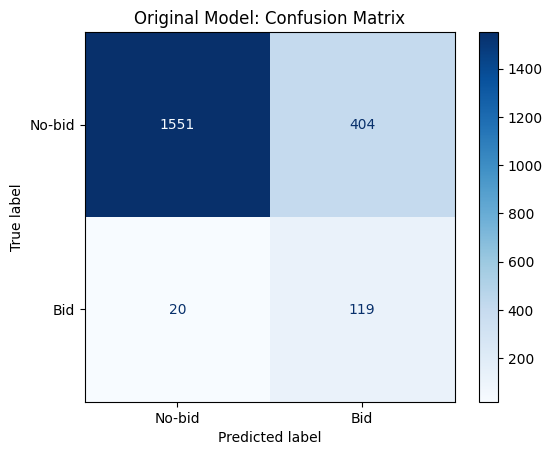


Original Model Classification Report:
              precision    recall  f1-score   support

           0      0.987     0.793     0.880      1955
           1      0.228     0.856     0.360       139

    accuracy                          0.798      2094
   macro avg      0.607     0.825     0.620      2094
weighted avg      0.937     0.798     0.845      2094



In [6]:
# Evaluate Original Model
results_original, proba_original, y_pred_original = evaluate_model(
    model_original, X_original, y_original, "Original TF-IDF LinearSVM"
)

# Show confusion matrix for original model
ConfusionMatrixDisplay.from_predictions(
    y_original, y_pred_original, display_labels=["No-bid", "Bid"], cmap="Blues"
)
plt.title("Original Model: Confusion Matrix")
plt.show()

print("\nOriginal Model Classification Report:")
print(classification_report(y_original, y_pred_original, digits=3))


Evaluating PDF Content Enhanced Model


/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/rober/GitHub/module_2/python/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of

Threshold for 85% recall: 0.054
Precision: 0.160
Recall: 0.856
F1-Score: 0.270
Documents to review: 518
Missed opportunities: 14


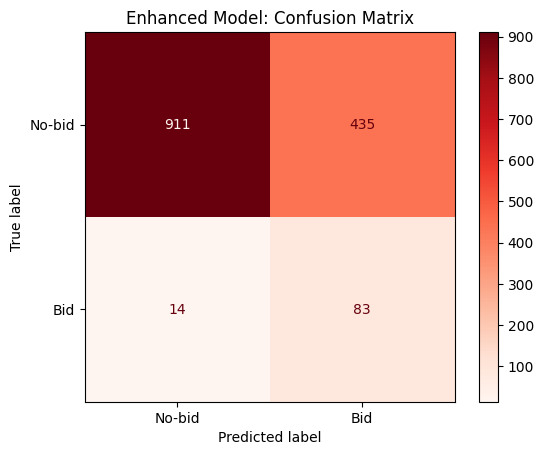


Enhanced Model Classification Report:
              precision    recall  f1-score   support

           0      0.985     0.677     0.802      1346
           1      0.160     0.856     0.270        97

    accuracy                          0.689      1443
   macro avg      0.573     0.766     0.536      1443
weighted avg      0.929     0.689     0.767      1443



In [7]:
# Evaluate PDF Content Enhanced Model
results_enhanced, proba_enhanced, y_pred_enhanced = evaluate_model(
    model_enhanced, X_enhanced, y_enhanced, "PDF Content Enhanced Model"
)

# Show confusion matrix for enhanced model
ConfusionMatrixDisplay.from_predictions(
    y_enhanced, y_pred_enhanced, display_labels=["No-bid", "Bid"], cmap="Reds"
)
plt.title("Enhanced Model: Confusion Matrix")
plt.show()

print("\nEnhanced Model Classification Report:")
print(classification_report(y_enhanced, y_pred_enhanced, digits=3))

In [8]:
# Direct Comparison Table
print("\n" + "="*80)
print("DIRECT MODEL COMPARISON")
print("="*80)

comparison_data = [
    {
        'Metric': 'Dataset Size',
        'Original': f"{results_original['dataset_size']:,}",
        'Enhanced': f"{results_enhanced['dataset_size']:,}",
        'Difference': f"{results_original['dataset_size'] - results_enhanced['dataset_size']:,}"
    },
    {
        'Metric': 'Positive Class Ratio',
        'Original': f"{results_original['positive_ratio']:.3f}",
        'Enhanced': f"{results_enhanced['positive_ratio']:.3f}",
        'Difference': f"{results_enhanced['positive_ratio'] - results_original['positive_ratio']:+.3f}"
    },
    {
        'Metric': 'Threshold (85% recall)',
        'Original': f"{results_original['threshold']:.3f}",
        'Enhanced': f"{results_enhanced['threshold']:.3f}",
        'Difference': f"{results_enhanced['threshold'] - results_original['threshold']:+.3f}"
    },
    {
        'Metric': 'Precision',
        'Original': f"{results_original['precision']:.3f}",
        'Enhanced': f"{results_enhanced['precision']:.3f}",
        'Difference': f"{results_enhanced['precision'] - results_original['precision']:+.3f}"
    },
    {
        'Metric': 'Recall',
        'Original': f"{results_original['recall']:.3f}",
        'Enhanced': f"{results_enhanced['recall']:.3f}",
        'Difference': f"{results_enhanced['recall'] - results_original['recall']:+.3f}"
    },
    {
        'Metric': 'F1-Score',
        'Original': f"{results_original['f1_score']:.3f}",
        'Enhanced': f"{results_enhanced['f1_score']:.3f}",
        'Difference': f"{results_enhanced['f1_score'] - results_original['f1_score']:+.3f}"
    },
    {
        'Metric': 'Documents to Review',
        'Original': f"{results_original['documents_to_review']}",
        'Enhanced': f"{results_enhanced['documents_to_review']}",
        'Difference': f"{results_enhanced['documents_to_review'] - results_original['documents_to_review']:+d}"
    },
    {
        'Metric': 'Missed Opportunities',
        'Original': f"{results_original['missed_opportunities']}",
        'Enhanced': f"{results_enhanced['missed_opportunities']}",
        'Difference': f"{results_original['missed_opportunities'] - results_enhanced['missed_opportunities']:+d}"
    },
    {
        'Metric': 'True Positives',
        'Original': f"{results_original['true_positives']}",
        'Enhanced': f"{results_enhanced['true_positives']}",
        'Difference': f"{results_enhanced['true_positives'] - results_original['true_positives']:+d}"
    },
    {
        'Metric': 'False Positives',
        'Original': f"{results_original['false_positives']}",
        'Enhanced': f"{results_enhanced['false_positives']}",
        'Difference': f"{results_enhanced['false_positives'] - results_original['false_positives']:+d}"
    }
]

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


DIRECT MODEL COMPARISON
                Metric Original Enhanced Difference
          Dataset Size    2,094    1,443        651
  Positive Class Ratio    0.066    0.067     +0.001
Threshold (85% recall)    0.061    0.054     -0.007
             Precision    0.228    0.160     -0.067
                Recall    0.856    0.856     -0.000
              F1-Score    0.360    0.270     -0.090
   Documents to Review      523      518         -5
  Missed Opportunities       20       14         +6
        True Positives      119       83        -36
       False Positives      404      435        +31
